In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import pickle as pickle
from tensorflow import keras
import tensorflow.keras.layers as layers
# from tensorflow.keras.models import Sequential
import glob
import random
import datetime
from pathlib import Path
from PIL import Image


def read_pil_image(img_path, height, width):
        with open(img_path, 'rb') as f:
            return np.array(Image.open(f).convert('RGB').resize((width, height)))

def load_all_images(dataset_path, height, width, img_ext='tif'):
    return np.array([read_pil_image(str(p), height, width) for p in 
                                    glob.glob(dataset_path+"*."+img_ext)[::200]]) 


directory = "/gws/nopw/j04/aopp/manshausen/bing_dl/train/patches/"
print(tf.config.list_physical_devices())

from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
                                rescale = 1./255,
                                featurewise_center=True,
                                featurewise_std_normalization=True,
                                validation_split=0.20,
                                # preprocessing_function= tf.keras.applications.resnet_v2.preprocess_input
)
             
height = width = 1400
train_datagen.fit(load_all_images( "/gws/nopw/j04/aopp/manshausen/bing_dl/train/patches/*/", height, width))

train_image_generator = train_datagen.flow_from_directory(
    directory,
    batch_size=10,
    # color_mode="grayscale",
    target_size=(height, width),
    class_mode='categorical',
    subset='training',
    seed=42,
    shuffle=True,
)
val_image_generator = train_datagen.flow_from_directory(
    directory,
    batch_size=10,
    # color_mode="grayscale",
    target_size=(height, width),
    class_mode='categorical',
    subset='validation',
    seed=42,
    shuffle=False,
)
# mirrored_strategy = tf.distribute.MirroredStrategy()
# with mirrored_strategy.scope():
model = tf.keras.Sequential([
    tf.keras.applications.resnet_v2.ResNet50V2(
    #
    # resize_rescale_augment,
    # layers.Conv2D(3, 5, padding='same', activation='tanh'), # this seems like a bit of a brute force approach to handing a 3 channel image to resnet, 
                                                            # maybe try changing the source so it accepts 4 channels?
    
        include_top=True,
        weights=None, # if I don't use the pre trained weights from image net, does it matter that i don't use the preprocessing step which reorders RGB to BGR and zero-centers wrt imagenet?
        input_shape=(height, width, 3),
        # pooling=max ,
        classes=3,),
    # layers.Flatten(), # does this make sense? or is there another way to get down to just three output dimensions?
    # layers.Dense(3)
    ])

met = tf.keras.metrics.CategoricalAccuracy()
lo = tf.keras.losses.CategoricalCrossentropy(from_logits=False)

log_dir = '/home/users/pete_nut/sentinel_industry/bingmaps/logs/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch = '120,140')

def scheduler(epoch, lr):
    if epoch < 100:
        return lr
    else:
        return lr * tf.math.exp(-0.02)
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
es_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=50,verbose=1, restore_best_weights=True)

model.compile(optimizer=keras.optimizers.Adam(),
              loss=lo, 
              metrics=[met])
model.build(input_shape=(height, width, 3)) #????
model.summary()


2023-01-20 19:05:00.489626: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-20 19:05:00.664139: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-20 19:05:00.664190: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-20 19:05:02.000842: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


2023-01-20 19:05:04.756732: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-01-20 19:05:04.756778: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-20 19:05:04.756814: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (host596.jc.rl.ac.uk): /proc/driver/nvidia/version does not exist


Found 6408 images belonging to 3 classes.
Found 1600 images belonging to 3 classes.


2023-01-20 19:05:16.899833: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 3)                 23570947  
                                                                 
Total params: 23,570,947
Trainable params: 23,525,507
Non-trainable params: 45,440
_________________________________________________________________


2023-01-20 19:05:18.060907: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-01-20 19:05:18.060950: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2023-01-20 19:05:18.061051: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.


In [7]:
model.load_weights('/gws/nopw/j04/aopp/manshausen/saved_bing_models/1400_more_steps_center.h5')

array([0, 0, 0, ..., 2, 2, 2], dtype=int32)

In [3]:
labels = val_image_generator.labels

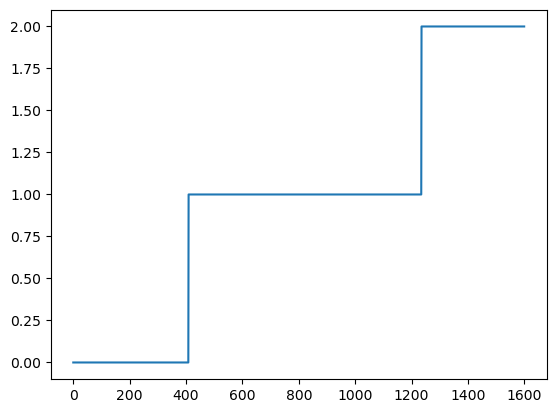

In [4]:
plt.plot(labels)

In [19]:
label_n = np.array([], dtype=int)
for i in labels:
    if (i == [0, 0, 1]).all():
        label_n = np.append(label_n,2)
    elif (i == [0, 1,0]).all():
        label_n = np.append(label_n,1)
    elif (i == [1, 0, 0]).all():
        label_n = np.append(label_n,0)    
    # print(label_n)

In [8]:
pred=model.predict(val_image_generator, verbose=2)

160/160 - 1017s - 1017s/epoch - 6s/step


In [9]:
np.shape(pred.numpy())

AttributeError: 'numpy.ndarray' object has no attribute 'numpy'

In [47]:
labels == np.argmax(pred, axis=1)

array([False,  True, False, ..., False, False, False])

In [16]:
np.argmax(pred, axis=1)

array([1, 0, 1, ..., 1, 1, 1])

In [6]:
import sklearn.metrics
print(sklearn.metrics.classification_report(labels, np.argmax(pred, axis=1), target_names=['coal','other', 'steel']))

              precision    recall  f1-score   support

        coal       0.77      0.62      0.68       409
       other       0.81      0.91      0.86       826
       steel       0.65      0.60      0.62       365

    accuracy                           0.77      1600
   macro avg       0.74      0.71      0.72      1600
weighted avg       0.76      0.77      0.76      1600



In [9]:
import sklearn.metrics #after leaving out augment
print(sklearn.metrics.classification_report(labels, np.argmax(pred, axis=1), target_names=['coal','other', 'steel']))

              precision    recall  f1-score   support

        coal       0.72      0.82      0.76       409
       other       0.85      0.93      0.89       826
       steel       0.84      0.53      0.65       365

    accuracy                           0.81      1600
   macro avg       0.80      0.76      0.77      1600
weighted avg       0.82      0.81      0.80      1600



In [37]:
print(np.round(sklearn.metrics.multilabel_confusion_matrix(labels, np.argmax(pred, axis=1) )/1600,2))

[[[0.72 0.02]
  [0.19 0.06]]

 [[0.18 0.3 ]
  [0.02 0.5 ]]

 [[0.74 0.03]
  [0.15 0.08]]]


In [36]:
sklearn.metrics.confusion_matrix(labels, np.argmax(pred, axis=1))/1600

array([[0.0625  , 0.16625 , 0.026875],
       [0.009375, 0.5     , 0.006875],
       [0.0125  , 0.135625, 0.08    ]])

In [68]:
np.shape(label_n)

(791,)

In [26]:
x_size, y_size = 230,230
off=0

def load_features(name):
    decoded = name
    if os.path.exists(decoded):
        with open(decoded, 'rb') as f:
            file = pickle.load(f)
            label = tf.strings.split(tf.strings.split(name, '/')[-1], '\\')[-2]
            if label == 'coal':
                label = [1,0,0]
            elif label == 'steel':
                label = [0,1,0]
            else: label = [0,0,1]
            if (file["B02"].shape[1]<230 or file["B02"].shape[2]<230): 
                print("oh oh, downloaded patch too smol:", decoded)
            B02, B03, B04, B08 = file['B02'][0][0:x_size,0:y_size], file['B03'][0][0:x_size,0:y_size], file['B04'][0][0:x_size,0:y_size],file['B08'][0][0:x_size,0:y_size]
            B02, B03, B04, B08 = B02[off:-off,off:-off], B03[off:-off,off:-off], B04[off:-off,off:-off], B08[off:-off,off:-off] 
            features = np.array([ B02, B03, B04, B08]).transpose(1,2,0)
            # features = np.expand_dims(features, axis=0)
            return features, label
            # I have commented the line below but this should return
            # the features and the label in a one hot vector
            # return file['features'], file['targets']
    else:
        print("Something went wrong!")
        exit(-1)
        
def data_loader(filename):
    features, labels = tf.numpy_function(load_features, [filename], [tf.double, tf.int32])
    # features.set_shape((None, 242,242,4))
    # labels.set_shape(( 1))
    return features, labels

path = 'E:/Users/sentinel_industry/downloaded_aois/coal/'

pkl_files = glob.glob((path+"*.pickle"))
path_steel = 'E:/Users/sentinel_industry/downloaded_aois/steel/'
pkl_files_steel = glob.glob((path_steel+"*.pickle"))
path_steel_no_ind = 'E:/Users/sentinel_industry/downloaded_aois/steel/no_ind/'
pkl_files_steel_no_ind = glob.glob((path_steel_no_ind+"*.pickle"))
path_coal_no_ind = 'E:/Users/sentinel_industry/downloaded_aois/coal/no_ind/'
pkl_files_coal_no_ind = glob.glob((path_coal_no_ind+"*.pickle"))
pkl_files = pkl_files + pkl_files_steel + pkl_files_steel_no_ind + pkl_files_coal_no_ind
random.Random(42).shuffle(pkl_files)
dataset_len=len(pkl_files)

train_size = int(np.floor(0.8 * dataset_len))
valid_size = int(np.floor(0.1 * dataset_len))
test_size = int(np.floor(0.1 * dataset_len))
valid_files = pkl_files[train_size+valid_size:]

In [76]:
np.argmax(pred.numpy(), axis=1)

array([1, 0, 1, 0, 2, 0, 2, 2, 0, 2, 2, 2, 0, 1, 2, 2, 2, 0, 2, 0, 2, 2,
       1, 2, 2, 1, 2, 2, 2, 0, 2, 2, 2, 0, 0, 0, 2, 1, 1, 1, 0, 0, 1, 2,
       2, 1, 0, 1, 2, 2, 1, 1, 0, 2, 2, 1, 0, 2, 2, 1, 0, 0, 2, 0, 0, 2,
       2, 1, 0, 2, 1, 2, 0, 2, 2, 1, 2, 2, 1, 0, 2, 0, 0, 2, 0, 2, 2, 2,
       0, 0, 2, 2, 0, 2, 1, 2, 2, 0, 1, 1, 2, 0, 1, 0, 0, 1, 1, 2, 2, 1,
       2, 2, 2, 0, 0, 1, 0, 2, 2, 2, 2, 0, 1, 2, 2, 2, 1, 1, 0, 0, 2, 2,
       0, 2, 2, 2, 2, 0, 0, 2, 2, 0, 2, 2, 0, 2, 2, 0, 2, 0, 2, 0, 2, 2,
       2, 2, 2, 2, 0, 2, 0, 1, 0, 2, 2, 0, 1, 0, 2, 1, 0, 1, 0, 0, 2, 2,
       2, 2, 2, 2, 1, 1, 2, 2, 2, 0, 1, 2, 0, 0, 2, 0, 1, 2, 2, 1, 2, 0,
       0, 1, 1, 0, 2, 1, 2, 1, 1, 0, 1, 2, 0, 2, 0, 2, 1, 2, 1, 2, 1, 2,
       0, 0, 0, 0, 0, 2, 2, 0, 2, 1, 2, 2, 2, 1, 2, 2, 2, 0, 1, 2, 0, 1,
       1, 2, 2, 0, 0, 1, 2, 2, 1, 1, 2, 2, 2, 1, 2, 2, 2, 0, 1, 2, 0, 1,
       1, 2, 0, 1, 1, 1, 2, 1, 2, 0, 2, 1, 2, 0, 2, 2, 2, 2, 1, 1, 2, 0,
       2, 1, 0, 2, 2, 0, 2, 2, 2, 0, 1, 1, 2, 0, 2,

In [27]:
x_s = 230-2*off
y_s = 230-2*off
in_seed = 42
resize_rescale_augment = tf.keras.Sequential([
    layers.RandomRotation(0.2, seed=in_seed, input_shape=(x_s,y_s,4)),  # here, maybe try larger values
    layers.CenterCrop(140,140, ),
    layers.RandomCrop(120,120, seed=in_seed, ),  # to be changed with centercrop for data augmentation/ use centre first, then random?
    
    # layers.Rescaling(1./10000),#,input_shape=(240,240,4)), # I think the data is scaled to 10000
    layers.RandomFlip("horizontal_and_vertical", seed=in_seed), 
    # norm_layer,
])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


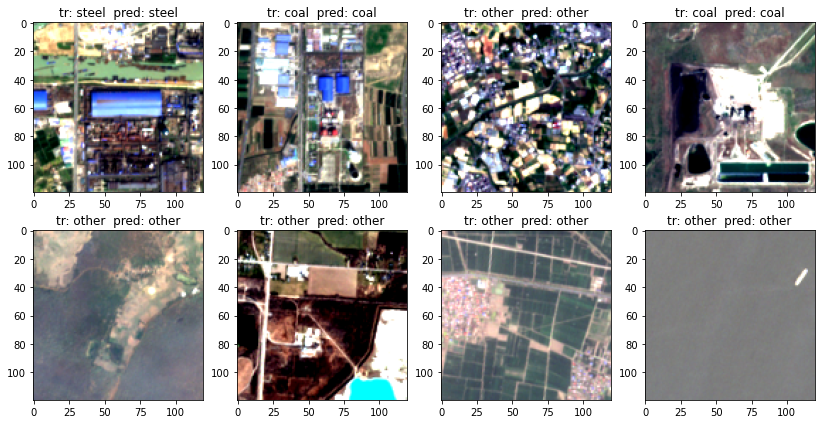

In [38]:
def convert_onehot(next_element):
    if (next_element == np.array([0, 0, 1])).all(): return 'other'
    elif (next_element == np.array([0, 1, 0])).all(): return 'steel'
    elif (next_element == np.array([1, 0, 0])).all(): return 'coal'
    else: return 'not valid'
def convert_label(next_element):
    if next_element == 2 : return 'other'
    elif next_element == 1 : return 'steel'
    elif next_element == 0 : return 'coal'
    else: return 'not valid'

plt.figure(figsize=(14, 7))

for i in range( 48,56):
    ax = plt.subplot(2, 4, i + 1 -48)
    loaded = load_features(valid_files[i]) 
    # print(loaded[1])
    # im = loaded[0]
    # plt.imshow(np.flip(im[:,:,0:3]/5000, axis=2))
    for da in valid.skip(i).take(1).as_numpy_iterator():
    # print(i[0].shape)
        im = resize_rescale_augment(tf.expand_dims(
    da[0], 0, name=None))
        plt.imshow((np.flip(im[0,:,:,0:3]-im[0,:,:,0:3].numpy().mean(axis=0).mean(axis=0)*1.+0.5,  axis=2)))
    plt.title('tr: ' + convert_label(label_n[i])+'  ' + 'pred: '+convert_label(np.argmax(pred.numpy(), axis=1)[i]))

plt.savefig('figures/prediction_example.pdf', dpi=300, format='pdf', bbox_inches='tight')

In [39]:
wrong_pred = np.where((label_n == np.argmax(pred.numpy(), axis=1)) == False)

In [40]:
wrong_pred

(array([ 14,  17,  59,  67,  70,  92,  95, 103, 108, 118, 135, 151, 155,
        178, 179, 188, 190, 201, 231, 234, 251, 271, 300, 334, 378, 409,
        436, 472, 546, 556, 600, 604, 618, 624, 626, 634, 636, 650, 656,
        682, 686, 701, 711, 716, 718, 739, 752, 759], dtype=int64),)

In [41]:
np.round(pred.numpy()[i].max(),2)

1.0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


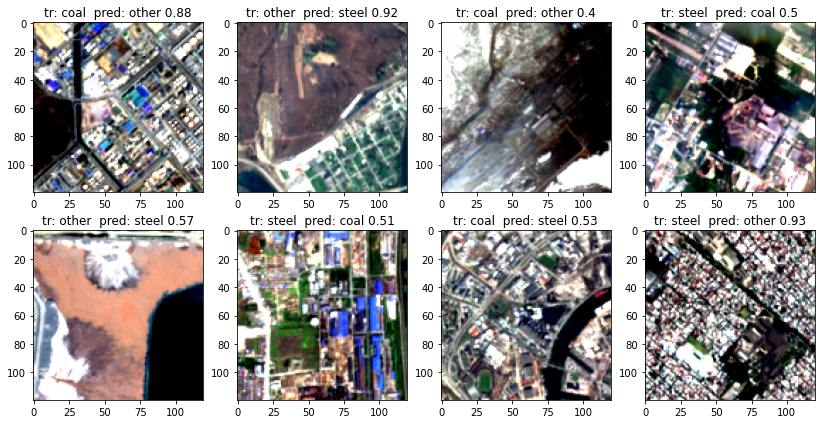

In [47]:
plt.figure(figsize=(14, 7))

for j,i in enumerate(wrong_pred[0][32:40]):
    ax = plt.subplot(2, 4, j + 1 )
    loaded = load_features(valid_files[i]) 
    # print(loaded[1])
    # im = loaded[0]
    # plt.imshow(np.flip(im[:,:,0:3]/5000, axis=2))
    for da in valid.skip(i).take(1).as_numpy_iterator():
    # print(i[0].shape)
        im = resize_rescale_augment(tf.expand_dims(
    da[0], 0, name=None))
        plt.imshow((np.flip(im[0,:,:,0:3]-im[0,:,:,0:3].numpy().mean(axis=0).mean(axis=0)*1.+0.5,  axis=2)))
    plt.title('tr: ' + convert_label(label_n[i])+'  ' + 'pred: '+convert_label(np.argmax(pred.numpy(), axis=1)[i])+ ' ' +str(np.round(pred.numpy()[i].max(),2)))
plt.savefig('figures/wrong_predictions.pdf', dpi=300, format='pdf', bbox_inches='tight')

In [ ]:
def convert_onehot(next_element):
    if (next_element == np.array([0, 0, 1])).all(): return 'no industry'
    elif (next_element == np.array([0, 1, 0])).all(): return 'steel'
    elif (next_element == np.array([1, 0, 0])).all(): return 'coal'
    else: return 'not valid'
def convert_label(next_element):
    if next_element == 2 : return 'no industry'
    elif next_element == 1 : return 'steel'
    elif next_element == 0 : return 'coal'
    else: return 'not valid'

plt.figure(figsize=(20, 20))

for i in range( 48,64):
    ax = plt.subplot(4, 4, i + 1 -48)
    loaded = load_features(valid_files[i]) 
    # print(loaded[1])
    # im = loaded[0]
    # plt.imshow(np.flip(im[:,:,0:3]/5000, axis=2))
    for da in valid.skip(i).take(1).as_numpy_iterator():
    # print(i[0].shape)
        im = resize_rescale_augment(tf.expand_dims(
    da[0], 0, name=None))
        plt.imshow((np.flip(im[0,:,:,0:3]-im[0,:,:,0:3].numpy().mean(axis=0).mean(axis=0)*1.+0.5,  axis=2)))
    plt.title('truth: ' + convert_label(label_n[i])+'  ' + 'prediction: '+convert_label(np.argmax(pred.numpy(), axis=1)[i]))
plt.savefig('figures/prediction_example', dpi=300, format='svg')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0, 1, 0]
[0, 0, 1]
[0, 0, 1]
[0, 1, 0]
[0, 0, 1]
[0, 0, 1]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0, 0, 1]
[1, 0, 0]
[0, 0, 1]
[0, 0, 1]
[0, 0, 1]
[1, 0, 0]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0, 1, 0]
[0, 0, 1]
[0, 0, 1]
[1, 0, 0]


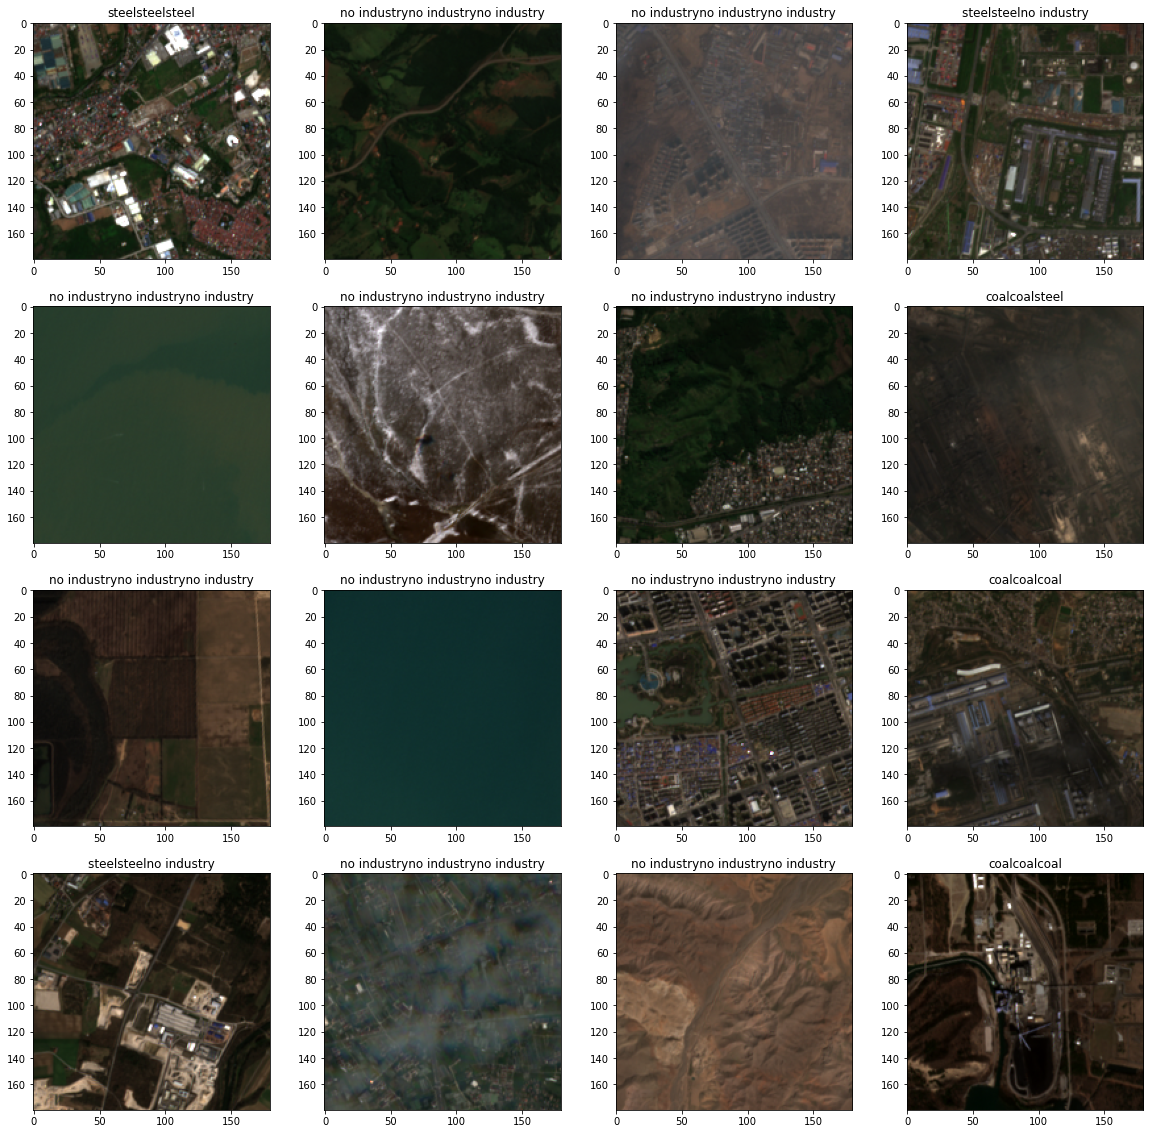

In [106]:
def convert_onehot(next_element):
    if (next_element == np.array([0, 0, 1])).all(): return 'no industry'
    elif (next_element == np.array([0, 1, 0])).all(): return 'steel'
    elif (next_element == np.array([1, 0, 0])).all(): return 'coal'
    else: return 'not valid'
def convert_label(next_element):
    if next_element == 2 : return 'no industry'
    elif next_element == 1 : return 'steel'
    elif next_element == 0 : return 'coal'
    else: return 'not valid'

plt.figure(figsize=(20, 20))

for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    loaded = load_features(valid_files[i]) 
    print(loaded[1])
    im = loaded[0]
    plt.imshow(np.flip(im[:,:,0:3]/5000, axis=2))
    plt.title(convert_onehot(loaded[1]) + convert_label(label_n[i]) +convert_label(np.argmax(pred.numpy(), axis=1)[i]))

In [46]:
im.shape

(230, 230, 4)

In [40]:
im

array([[[ 755,  982, 1426, 2580],
        [ 808, 1070, 1394, 2746],
        [1124, 1404, 1456, 3040],
        ...,
        [ 674,  968, 1078, 2448],
        [ 786,  908, 1460, 1936],
        [1278, 1432, 1842, 2154]],

       [[ 847, 1076, 1480, 2634],
        [ 846, 1122, 1470, 2702],
        [ 982, 1320, 1512, 2902],
        ...,
        [ 708, 1007, 1190, 2574],
        [1004,  973, 1001, 1706],
        [1490, 1356, 1760, 2288]],

       [[ 907, 1132, 1556, 2728],
        [ 907, 1130, 1572, 2752],
        [ 973, 1316, 1622, 2876],
        ...,
        [ 879, 1234, 1400, 2204],
        [1200, 1024, 1130, 1986],
        [1472, 1020, 1272, 2406]],

       ...,

       [[ 438,  858,  656, 3164],
        [ 428,  703,  625, 2962],
        [ 354,  721,  639, 2846],
        ...,
        [ 676,  946, 1154, 3318],
        [ 827, 1206, 1190, 3312],
        [1138, 1516, 1572, 3112]],

       [[ 424,  777,  660, 2750],
        [ 514,  798,  672, 2524],
        [ 455,  768,  741, 2456],
        .

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


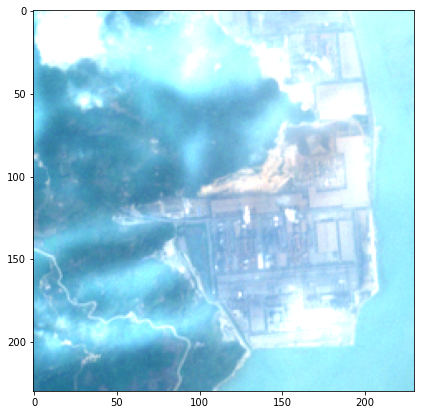

In [422]:
plt.figure(figsize=(7,7))
im = load_features(valid_files[index])[0]
plt.imshow((np.flip(im[:,:,0:3]+np.abs(im.mean())*0+0.5, axis=2)))


In [397]:
valid_files[index]

'E:/Users/sentinel_industry/downloaded_aois/steel/no_ind\\GASTDEU0005.pickle'

In [398]:
discard_list.append(valid_files[index])

In [424]:
np.save('discard2half', np.array( discard_list))

In [425]:
for file in discard_list:
    os.remove(file)

In [ ]:
# plt.figure(figsize=(7,7))
# for i in valid.skip(index).take(1).as_numpy_iterator():
#     print(i[0].shape)
#     im = i[0]
#     plt.imshow((np.flip(im[:,:,0:3]+np.abs(im.mean())*2, axis=2)))